cifar10 patch reconstruction using stochastic interpolants

this implementation:
- trains on dog class only (cifar10 class 5)
- uses mask-conditioned u-net architecture
- learns to reconstruct masked patches while keeping visible pixels fixed
- conditions on mask during both training and generation
- forces visible pixels to remain constant in output

approach:
  x0 = masked_image * mask + noise * (1-mask)  # we start with visible pixels + noise in masked regions
  x1 = original_image                           # we target full image
  model learns interpolant: x0 -> x1 conditioned on mask
  during generation: output = model_output * (1-mask) + original * mask  # we force visible pixels fixed

In [1]:

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import time
import sys
sys.path.append('../../')
from typing import Tuple, Any

import interflow as itf
import interflow.stochastic_interpolant as stochastic_interpolant

if torch.cuda.is_available():
    print('cuda available, setting default tensor residence to gpu')
    itf.util.set_torch_device('cuda')
else:
    print('no cuda device found')
print(itf.util.get_torch_device())

print("torch version:", torch.__version__)

cuda available, setting default tensor residence to gpu
cuda
torch version: 2.9.0+cu128


/Data/janis.aiad/probgraph/.venv/lib/python3.11/site-packages/torch/__init__.py:1275: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /pytorch/torch/csrc/tensor/python_tensor.cpp:434.)
  _C._set_default_tensor_type(t)


we define utility functions

In [2]:
def grab(var):
    """we take a tensor off the gpu and convert it to a numpy array on the cpu"""
    return var.detach().cpu().numpy()

we load cifar10 dataset

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root="../../data/cifar10", train=True, 
                                        download=True, transform=transform)

# we filter dataset to keep only dog class (class 5)
# cifar10 classes: 0=airplane, 1=automobile, 2=bird, 3=cat, 4=deer, 5=dog, 6=frog, 7=horse, 8=ship, 9=truck
target_class = 5  # we select dog class
dog_indices = [i for i in range(len(trainset)) if trainset.targets[i] == target_class]
print(f"\nfiltered dataset to class 'dog': {len(dog_indices)} images (out of {len(trainset)} total)")

# we create data iterator that only samples from dog images
def get_cifar_batch(bs):
    """we get a batch of cifar10 dog images only"""
    indices = torch.randint(0, len(dog_indices), (bs,))
    imgs = torch.stack([trainset[dog_indices[i]][0] for i in indices])
    return imgs.to(itf.util.get_torch_device())

# we create masking function for patches
def create_patch_mask(bs, patch_size=8, num_patches=4):
    """we create random patch masks, 1 for visible pixels, 0 for masked patches"""
    mask = torch.ones(bs, 3, 32, 32)
    for i in range(bs):
        for _ in range(num_patches):
            x = torch.randint(0, 32 - patch_size, (1,)).item()
            y = torch.randint(0, 32 - patch_size, (1,)).item()
            mask[i, :, x:x+patch_size, y:y+patch_size] = 0  # we mask the patch
    return mask.to(itf.util.get_torch_device())


filtered dataset to class 'dog': 5000 images (out of 50000 total)


we define u-net style convolutional denoiser for image reconstruction

In [4]:
class UNetDenoiser(nn.Module):
    """we use u-net architecture with skip connections for image reconstruction, conditioned on mask"""
    def __init__(self, in_channels=5, out_channels=3, base_channels=64):  # we add 1 channel for mask conditioning
        super().__init__()
        
        # we define encoder (downsampling path)
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_channels, base_channels, 3, padding=1),
            nn.GroupNorm(8, base_channels),
            nn.ReLU(),
            nn.Conv2d(base_channels, base_channels, 3, padding=1),
            nn.GroupNorm(8, base_channels),
            nn.ReLU()
        )
        
        self.enc2 = nn.Sequential(
            nn.Conv2d(base_channels, base_channels*2, 3, stride=2, padding=1),
            nn.GroupNorm(8, base_channels*2),
            nn.ReLU(),
            nn.Conv2d(base_channels*2, base_channels*2, 3, padding=1),
            nn.GroupNorm(8, base_channels*2),
            nn.ReLU()
        )
        
        self.enc3 = nn.Sequential(
            nn.Conv2d(base_channels*2, base_channels*4, 3, stride=2, padding=1),
            nn.GroupNorm(8, base_channels*4),
            nn.ReLU(),
            nn.Conv2d(base_channels*4, base_channels*4, 3, padding=1),
            nn.GroupNorm(8, base_channels*4),
            nn.ReLU()
        )
        
        # we define bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(base_channels*4, base_channels*8, 3, stride=2, padding=1),
            nn.GroupNorm(8, base_channels*8),
            nn.ReLU(),
            nn.Conv2d(base_channels*8, base_channels*8, 3, padding=1),
            nn.GroupNorm(8, base_channels*8),
            nn.ReLU()
        )
        
        # we define decoder (upsampling path) with skip connections
        self.dec3 = nn.Sequential(
            nn.ConvTranspose2d(base_channels*8, base_channels*4, 3, stride=2, padding=1, output_padding=1),
            nn.GroupNorm(8, base_channels*4),
            nn.ReLU()
        )
        self.dec3_conv = nn.Sequential(
            nn.Conv2d(base_channels*8, base_channels*4, 3, padding=1),
            nn.GroupNorm(8, base_channels*4),
            nn.ReLU(),
            nn.Conv2d(base_channels*4, base_channels*4, 3, padding=1),
            nn.GroupNorm(8, base_channels*4),
            nn.ReLU()
        )
        
        self.dec2 = nn.Sequential(
            nn.ConvTranspose2d(base_channels*4, base_channels*2, 3, stride=2, padding=1, output_padding=1),
            nn.GroupNorm(8, base_channels*2),
            nn.ReLU()
        )
        self.dec2_conv = nn.Sequential(
            nn.Conv2d(base_channels*4, base_channels*2, 3, padding=1),
            nn.GroupNorm(8, base_channels*2),
            nn.ReLU(),
            nn.Conv2d(base_channels*2, base_channels*2, 3, padding=1),
            nn.GroupNorm(8, base_channels*2),
            nn.ReLU()
        )
        
        self.dec1 = nn.Sequential(
            nn.ConvTranspose2d(base_channels*2, base_channels, 3, stride=2, padding=1, output_padding=1),
            nn.GroupNorm(8, base_channels),
            nn.ReLU()
        )
        self.dec1_conv = nn.Sequential(
            nn.Conv2d(base_channels*2, base_channels, 3, padding=1),
            nn.GroupNorm(8, base_channels),
            nn.ReLU(),
            nn.Conv2d(base_channels, base_channels, 3, padding=1),
            nn.GroupNorm(8, base_channels),
            nn.ReLU()
        )
        
        # we define final output layer
        self.final = nn.Conv2d(base_channels, out_channels, 1)
    
    def forward(self, x_with_t):
        """we forward pass with skip connections"""
        # we encode
        e1 = self.enc1(x_with_t)
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)
        
        # we process bottleneck
        b = self.bottleneck(e3)
        
        # we decode with skip connections
        d3 = self.dec3(b)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3_conv(d3)
        
        d2 = self.dec2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2_conv(d2)
        
        d1 = self.dec1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1_conv(d1)
        
        # we output final reconstruction
        out = self.final(d1)
        return out

we define wrapper for eta network to match expected interface

In [5]:
class EtaNetwork(nn.Module):
    """we wrap unet to accept concatenated [x, t, mask] input"""
    def __init__(self, unet):
        super().__init__()
        self.unet = unet
        self.mask = None  # we store mask for conditioning
    
    def set_mask(self, mask):
        """we set the mask for conditioning"""
        self.mask = mask
    
    def forward(self, xt, t=None):
        """we support xt with or without appended time; t may be provided separately"""
        if xt.dim() == 1:
            xt = xt.unsqueeze(0)  # we ensure batch dimension
        bs = xt.shape[0]
        feat_dim = xt.shape[1]
        expected_x_dim = 3 * 32 * 32  # we expected flattened image dim
        
        if feat_dim == expected_x_dim + 1:
            x_flat = xt[:, :-1]  # we split x and t when t is appended
            t_vec = xt[:, -1:].to(device=xt.device, dtype=xt.dtype)  # we take t from input
        elif feat_dim == expected_x_dim:
            if t is None:
                raise RuntimeError("t must be provided when xt has no appended time")  # we enforce presence of t
            if not isinstance(t, torch.Tensor):
                t_vec = torch.tensor(t, device=xt.device, dtype=xt.dtype)  # we wrap python scalar/array
            else:
                t_vec = t.to(device=xt.device, dtype=xt.dtype)  # we move to same device/dtype
            numel = t_vec.numel()
            if numel == 1:
                t_vec = t_vec.reshape(1, 1).expand(bs, 1)  # we broadcast single time to batch
            elif numel == bs:
                t_vec = t_vec.reshape(bs, 1)  # we ensure shape [bs,1]
            else:
                raise RuntimeError(f"t has {numel} elements; expected 1 or {bs}")  # we guard invalid sizes
            x_flat = xt  # we use full vector as x
        else:
            raise RuntimeError(f"unexpected feature dimension {feat_dim}; expected {expected_x_dim} or {expected_x_dim+1}")  # we guard invalid dims
        
        x = x_flat.reshape(bs, 3, 32, 32)  # we reshape to image
        t_channel = t_vec.view(bs, 1, 1, 1).expand(bs, 1, 32, 32)  # we spatially broadcast t
        
        # we add mask conditioning (use first channel of mask for simplicity)
        if self.mask is not None:
            mask_channel = self.mask[:bs, 0:1, :, :]  # we take first channel of mask [bs, 1, 32, 32]
        else:
            mask_channel = torch.ones(bs, 1, 32, 32, device=x.device)  # we default to all visible
        
        x_with_t_mask = torch.cat([x, t_channel, mask_channel], dim=1)  # we concatenate [x, t, mask]
        
        # we process through unet
        out = self.unet(x_with_t_mask)
        
        # we flatten output
        return out.reshape(bs, -1)

# we define velocity field wrapper
class VelocityNetwork(nn.Module):
    """we wrap unet for velocity field b, conditioned on mask"""
    def __init__(self, unet):
        super().__init__()
        self.unet = unet
        self.mask = None  # we store mask for conditioning
    
    def set_mask(self, mask):
        """we set the mask for conditioning"""
        self.mask = mask
    
    def forward(self, xt, t=None):
        """we support xt with or without appended time; t may be provided separately"""
        if xt.dim() == 1:
            xt = xt.unsqueeze(0)  # we ensure batch dimension
        bs = xt.shape[0]
        feat_dim = xt.shape[1]
        expected_x_dim = 3 * 32 * 32  # we expected flattened image dim
        
        if feat_dim == expected_x_dim + 1:
            x_flat = xt[:, :-1]  # we split x and t when t is appended
            t_vec = xt[:, -1:].to(device=xt.device, dtype=xt.dtype)  # we take t from input
        elif feat_dim == expected_x_dim:
            if t is None:
                raise RuntimeError("t must be provided when xt has no appended time")  # we enforce presence of t
            if not isinstance(t, torch.Tensor):
                t_vec = torch.tensor(t, device=xt.device, dtype=xt.dtype)  # we wrap python scalar/array
            else:
                t_vec = t.to(device=xt.device, dtype=xt.dtype)  # we move to same device/dtype
            numel = t_vec.numel()
            if numel == 1:
                t_vec = t_vec.reshape(1, 1).expand(bs, 1)  # we broadcast single time to batch
            elif numel == bs:
                t_vec = t_vec.reshape(bs, 1)  # we ensure shape [bs,1]
            else:
                raise RuntimeError(f"t has {numel} elements; expected 1 or {bs}")  # we guard invalid sizes
            x_flat = xt  # we use full vector as x
        else:
            raise RuntimeError(f"unexpected feature dimension {feat_dim}; expected {expected_x_dim} or {expected_x_dim+1}")  # we guard invalid dims
        
        x = x_flat.reshape(bs, 3, 32, 32)  # we reshape to image
        t_channel = t_vec.view(bs, 1, 1, 1).expand(bs, 1, 32, 32)  # we spatially broadcast t
        
        # we add mask conditioning (use first channel of mask for simplicity)
        if self.mask is not None:
            mask_channel = self.mask[:bs, 0:1, :, :]  # we take first channel of mask [bs, 1, 32, 32]
        else:
            mask_channel = torch.ones(bs, 1, 32, 32, device=x.device)  # we default to all visible
        
        x_with_t_mask = torch.cat([x, t_channel, mask_channel], dim=1)  # we concatenate [x, t, mask]
        
        # we process through unet
        out = self.unet(x_with_t_mask)
        
        # we flatten output
        return out.reshape(bs, -1)

we define training step function

In [6]:
def train_step(
    bs: int,
    interpolant: stochastic_interpolant.Interpolant,
    opt_b: Any,
    opt_eta: Any,
    sched_b: Any,
    sched_eta: Any,
    patch_size: int,
    num_patches: int,
    mask_loss_weight: float = 10.0
):
    """we take a single step of optimization on the training set"""
    opt_b.zero_grad()
    opt_eta.zero_grad()
    
    # we construct batch of real images
    x1s_img = get_cifar_batch(bs)  # we get [bs, 3, 32, 32]
    
    # we create masks
    masks = create_patch_mask(bs, patch_size=patch_size, num_patches=num_patches)  # we get [bs, 3, 32, 32]
    
    # we create masked images + noise in masked regions as starting point
    noise = torch.randn_like(x1s_img) * (1 - masks)  # we add noise only in masked regions
    x0s_img = x1s_img * masks + noise  # we combine masked image and noise
    
    # we flatten for interpolant
    x0s = x0s_img.reshape(bs, -1)  # we flatten to [bs, 3072]
    x1s = x1s_img.reshape(bs, -1)  # we flatten to [bs, 3072]
    masks_flat = masks.reshape(bs, -1)  # we flatten mask too
    
    # we sample random times
    ts = torch.rand(size=(bs,)).to(itf.util.get_torch_device())
    
    # we set masks for conditioning in both networks
    b.set_mask(masks)
    eta.set_mask(masks)
    
    # we compute the losses
    loss_start = time.perf_counter()
    loss_b_full = loss_fn_b(b, x0s, x1s, ts, interpolant)
    loss_eta_full = loss_fn_eta(eta, x0s, x1s, ts, interpolant)
    
    # we weight the loss to focus on masked regions (multiply by mask_loss_weight for masked pixels)
    # we compute per-pixel weight: visible pixels get weight 1.0, masked pixels get weight mask_loss_weight
    loss_weights = masks_flat + mask_loss_weight * (1 - masks_flat)  # we create per-pixel weights
    
    # we apply weighted loss (approximation: we multiply total loss by average weight)
    avg_weight = loss_weights.mean()
    loss_b = loss_b_full * avg_weight
    loss_eta = loss_eta_full * avg_weight
    
    loss_val = loss_b + loss_eta
    loss_end = time.perf_counter()
    
    # we compute the gradient
    backprop_start = time.perf_counter()
    loss_b.backward()
    loss_eta.backward()
    b_grad = torch.tensor([torch.nn.utils.clip_grad_norm_(b.parameters(), float('inf'))])
    eta_grad = torch.tensor([torch.nn.utils.clip_grad_norm_(eta.parameters(), float('inf'))])
    backprop_end = time.perf_counter()
    
    # we perform the update
    update_start = time.perf_counter()
    opt_b.step()
    opt_eta.step()
    sched_b.step()
    sched_eta.step()
    update_end = time.perf_counter()
    
    if counter < 5:
        print(f'[loss: {loss_end - loss_start:.4f}s], [backprop: {backprop_end-backprop_start:.4f}s], [update: {update_end-update_start:.4f}s]')
    
    return loss_val.detach(), loss_b.detach(), loss_eta.detach(), b_grad.detach(), eta_grad.detach()

we define visualization function

In [7]:
def make_plots(
    b: torch.nn.Module,
    eta: torch.nn.Module,
    interpolant: stochastic_interpolant.Interpolant,
    counter: int,
    data_dict: dict,
    patch_size: int,
    num_patches: int
):
    """we make plots to visualize reconstruction results"""
    print(f"\nepoch: {counter}")
    
    # we get a batch for visualization
    vis_bs = 4
    x1s_img = get_cifar_batch(vis_bs)
    masks = create_patch_mask(vis_bs, patch_size=patch_size, num_patches=num_patches)
    
    # we create masked images
    noise = torch.randn_like(x1s_img) * (1 - masks)
    x0s_img = x1s_img * masks + noise
    
    # we reconstruct using probability flow
    x0s = x0s_img.reshape(vis_bs, -1)
    x1s = x1s_img.reshape(vis_bs, -1)
    
    # we use simple forward integration
    with torch.no_grad():
        # we set masks for conditioning during generation
        b.set_mask(masks)
        eta.set_mask(masks)
        
        s = stochastic_interpolant.SFromEta(eta, interpolant.a)
        pflow = stochastic_interpolant.PFlowIntegrator(
            b=b, method='rk4', interpolant=interpolant, n_step=5, sample_only=True
        )
        xfs_pflow, _ = pflow.rollout(x0s)
        xf_pflow_raw = xfs_pflow[-1].reshape(vis_bs, 3, 32, 32)
        
        # we force visible pixels to remain fixed (only reconstruct masked regions)
        xf_pflow = xf_pflow_raw * (1 - masks) + x1s_img * masks  # we keep original pixels where mask=1
    
    # we plot results
    fig, axes = plt.subplots(3, vis_bs, figsize=(vis_bs*2, 6))
    
    for i in range(vis_bs):
        # we denormalize images for visualization
        def denorm(img):
            return img * 0.5 + 0.5
        
        # we show original image
        axes[0, i].imshow(np.transpose(grab(denorm(x1s_img[i])), (1, 2, 0)))
        axes[0, i].axis('off')
        if i == 0:
            axes[0, i].set_title('original', fontsize=10)
        
        # we show masked image
        axes[1, i].imshow(np.transpose(grab(denorm(x0s_img[i])), (1, 2, 0)))
        axes[1, i].axis('off')
        if i == 0:
            axes[1, i].set_title('masked', fontsize=10)
        
        # we show reconstructed image
        axes[2, i].imshow(np.transpose(grab(denorm(xf_pflow[i])), (1, 2, 0)))
        axes[2, i].axis('off')
        if i == 0:
            axes[2, i].set_title('reconstructed', fontsize=10)
    
    plt.suptitle(f'dog patch reconstruction - epoch {counter}', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.savefig(f'dog_reconstruction_epoch_{counter}.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # we plot training curves
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    epochs = np.arange(len(data_dict['losses'])) * metrics_freq
    
    # we plot losses
    axes[0].plot(epochs, data_dict['losses'], label='total loss', linewidth=2)
    axes[0].plot(epochs, data_dict['b_losses'], label='b loss', alpha=0.7)
    axes[0].plot(epochs, data_dict['eta_losses'], label='eta loss', alpha=0.7)
    axes[0].set_xlabel('epoch')
    axes[0].set_ylabel('loss')
    axes[0].set_title('training loss (dog class)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # we plot gradients
    axes[1].plot(epochs, data_dict['b_grads'], label='b grad norm', linewidth=2)
    axes[1].plot(epochs, data_dict['eta_grads'], label='eta grad norm', linewidth=2)
    axes[1].set_xlabel('epoch')
    axes[1].set_ylabel('gradient norm')
    axes[1].set_title('gradient norms')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # we plot learning rates
    axes[2].plot(epochs, data_dict['lrs'], label='learning rate', linewidth=2)
    axes[2].set_xlabel('epoch')
    axes[2].set_ylabel('learning rate')
    axes[2].set_title('learning rate schedule')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'dog_training_curves_epoch_{counter}.png', dpi=150, bbox_inches='tight')
    plt.show()

we define main training setup


hyperparameters:
  class: dog (cifar10 class 5)
  batch_size: 32
  learning_rate: 0.0001
  n_epochs: 5000
  patch_size: 8
  num_patches: 4

conditioning approach:
  - networks conditioned on binary mask (visible=1, masked=0)
  - visible pixels kept fixed during generation
  - only masked regions are reconstructed

using interpolant: one-sided-linear

creating u-net architectures with mask conditioning...
b network parameters: 8,565,315
eta network parameters: 8,565,315

starting training...



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.92904866..2.0990517].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0877161..2.1668816].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0740577..2.1277716].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1706705..2.1097026].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.340351..1.894273].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.252441..1.9987246].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1356404.

[loss: 0.1255s], [backprop: 0.0556s], [update: 0.0211s]
epoch 1: loss=1199.8042, b_loss=550.1530, eta_loss=649.6511

epoch: 1


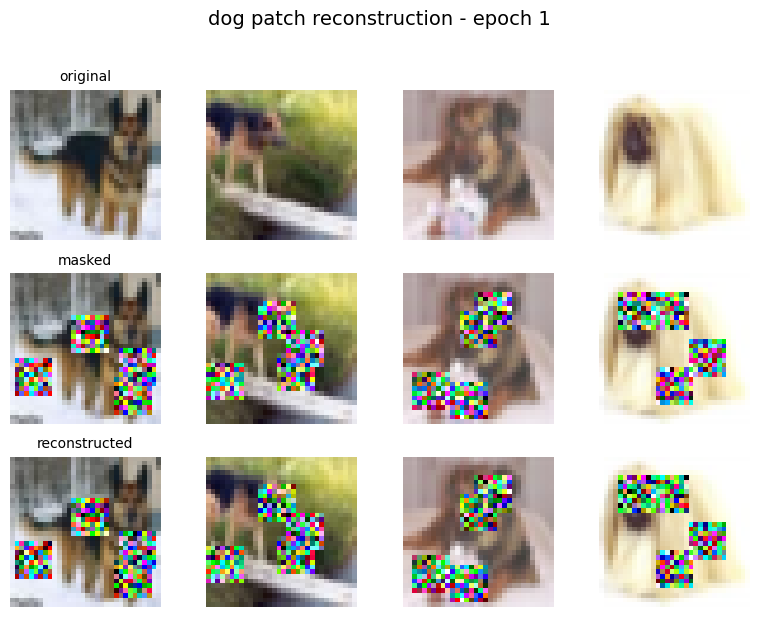

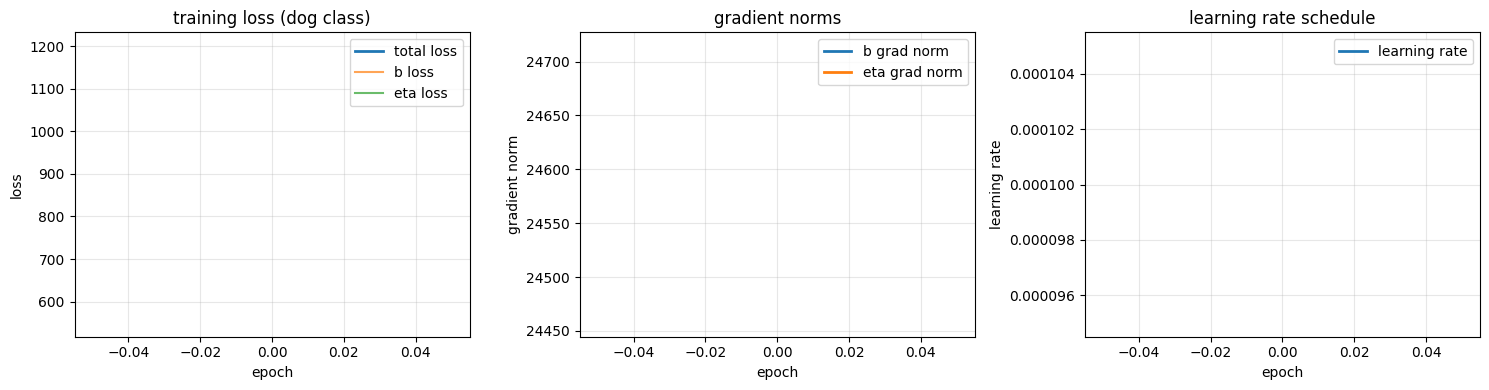

saved checkpoint at epoch 1
[loss: 0.0039s], [backprop: 0.0177s], [update: 0.0050s]
[loss: 0.0031s], [backprop: 0.0184s], [update: 0.0050s]
[loss: 0.0032s], [backprop: 0.0220s], [update: 0.0044s]
epoch 101: loss=-2104.1904, b_loss=-682.4459, eta_loss=-1421.7446
epoch 201: loss=-2468.9595, b_loss=-770.8498, eta_loss=-1698.1096
epoch 301: loss=-2646.8921, b_loss=-958.1400, eta_loss=-1688.7522
epoch 401: loss=-2521.7314, b_loss=-926.7209, eta_loss=-1595.0106


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1786728..2.1318574].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.15502214..1.134649].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.352392..1.9214354].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.05369228..1.2232077].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.76731324..2.424056].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.019942045..1.2395358].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9072

epoch 501: loss=-2737.0361, b_loss=-967.7161, eta_loss=-1769.3199

epoch: 501


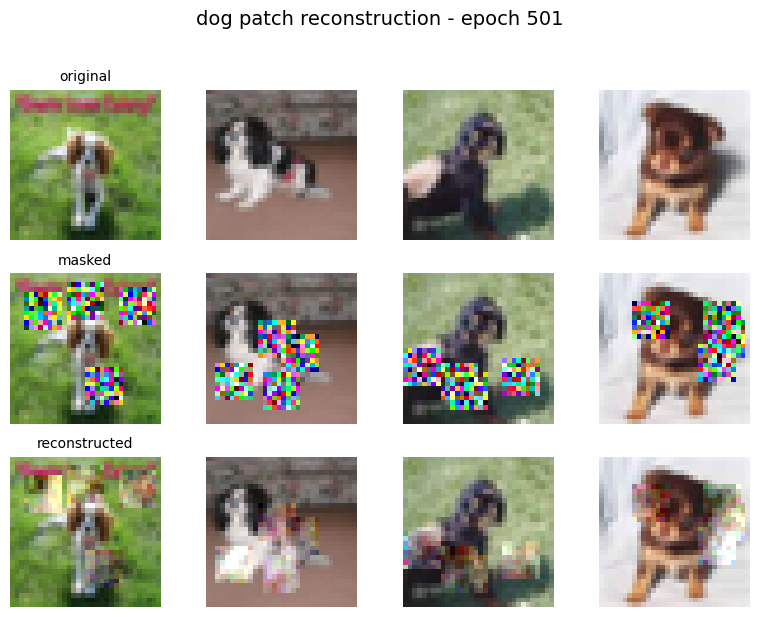

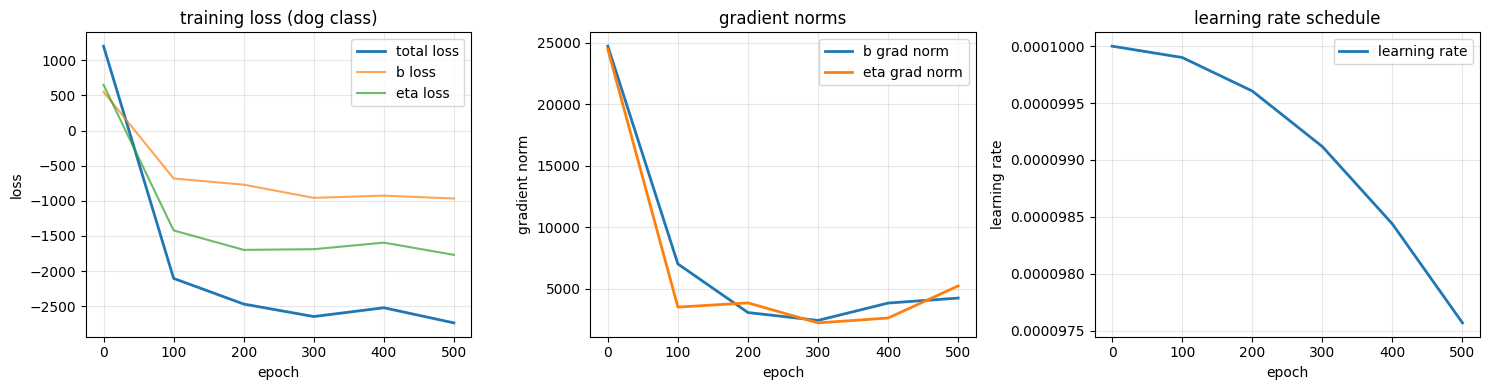

saved checkpoint at epoch 501
epoch 601: loss=-2626.6130, b_loss=-885.5581, eta_loss=-1741.0549
epoch 701: loss=-2806.7263, b_loss=-999.2499, eta_loss=-1807.4764
epoch 801: loss=-2669.3752, b_loss=-1005.1309, eta_loss=-1664.2443
epoch 901: loss=-2746.9338, b_loss=-1003.5529, eta_loss=-1743.3810


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.66832054..2.193172].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.02897495..0.9451517].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1588869..1.8955249].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.34194446..0.9882353].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4225..1.8117734].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.34736127..0.9791982].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.912809

epoch 1001: loss=-2607.6206, b_loss=-922.9260, eta_loss=-1684.6947

epoch: 1001


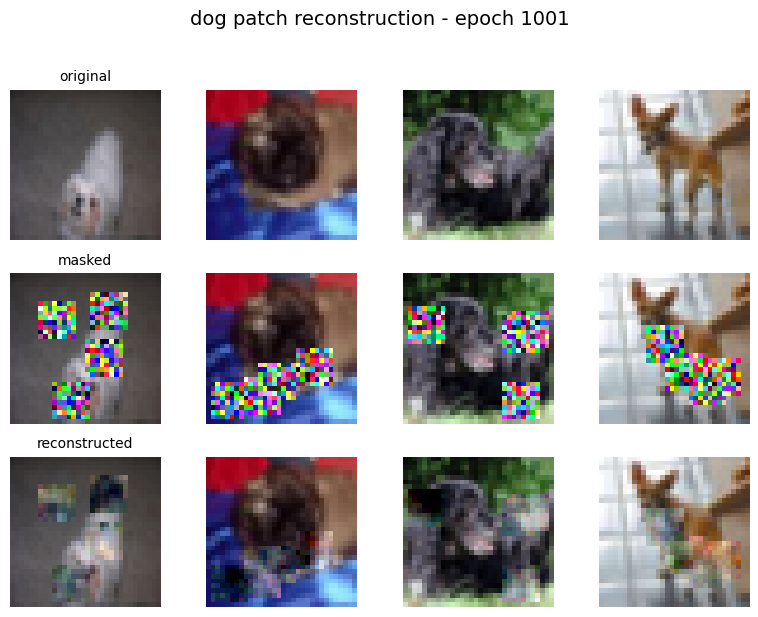

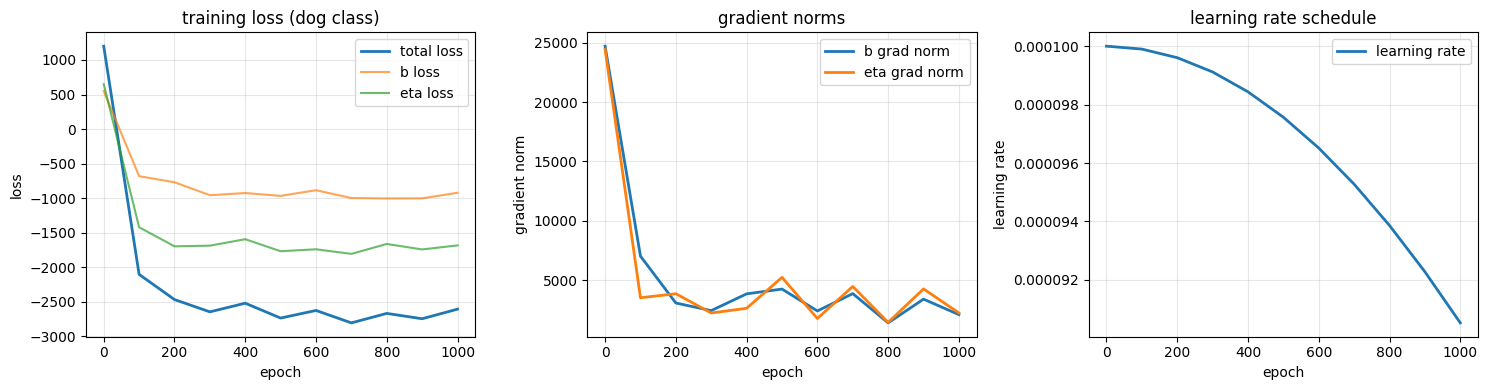

saved checkpoint at epoch 1001
epoch 1101: loss=-2734.7322, b_loss=-981.9819, eta_loss=-1752.7502
epoch 1201: loss=-2790.5908, b_loss=-979.7056, eta_loss=-1810.8851
epoch 1301: loss=-2807.1553, b_loss=-1015.0824, eta_loss=-1792.0730
epoch 1401: loss=-2560.5032, b_loss=-927.1815, eta_loss=-1633.3217


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9860172..1.8813834].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.07363713..0.90744185].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.97153175..1.9844997].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.94429815..2.3680758].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.021922886..0.99443114].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0643942..1.7848532].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.

epoch 1501: loss=-2615.6912, b_loss=-910.6622, eta_loss=-1705.0291

epoch: 1501


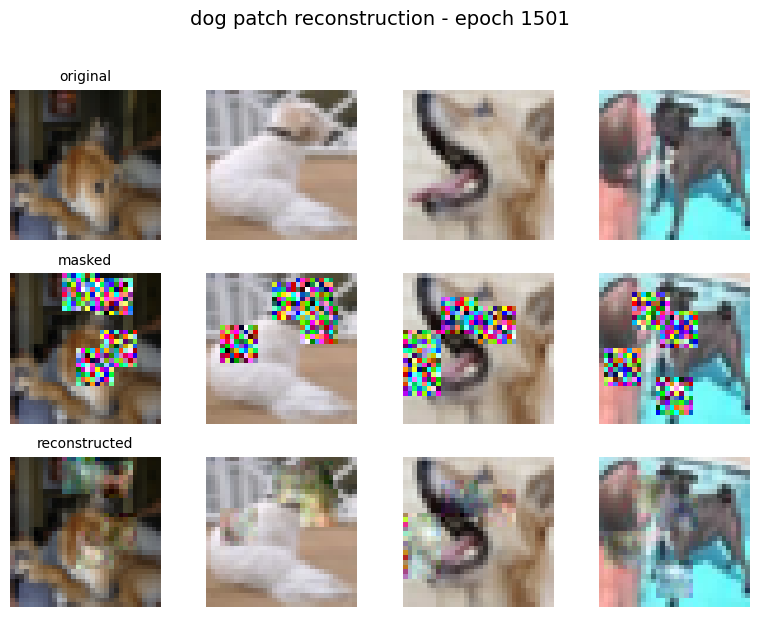

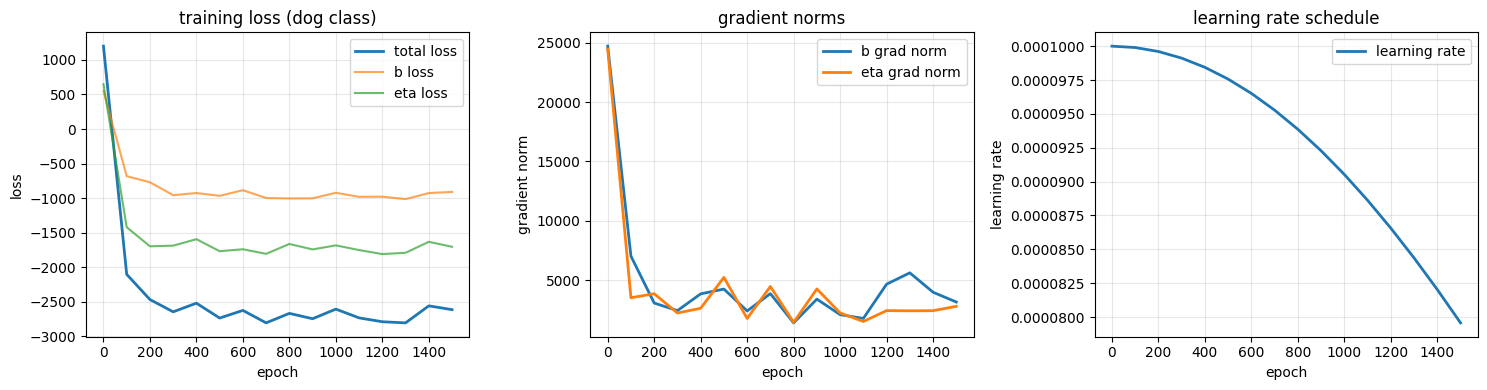

saved checkpoint at epoch 1501
epoch 1601: loss=-2819.1392, b_loss=-985.8460, eta_loss=-1833.2932
epoch 1701: loss=-2756.7583, b_loss=-946.5540, eta_loss=-1810.2045
epoch 1801: loss=-2717.2737, b_loss=-1021.0079, eta_loss=-1696.2659
epoch 1901: loss=-2673.1038, b_loss=-961.5505, eta_loss=-1711.5532


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.95340216..2.1873295].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2209103..1.9707977].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.13333333..1.1657065].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.232879..2.1477528].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.1602825..0.99607843].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8157077..2.1711597].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.11134

epoch 2001: loss=-2896.1968, b_loss=-1045.5814, eta_loss=-1850.6155

epoch: 2001


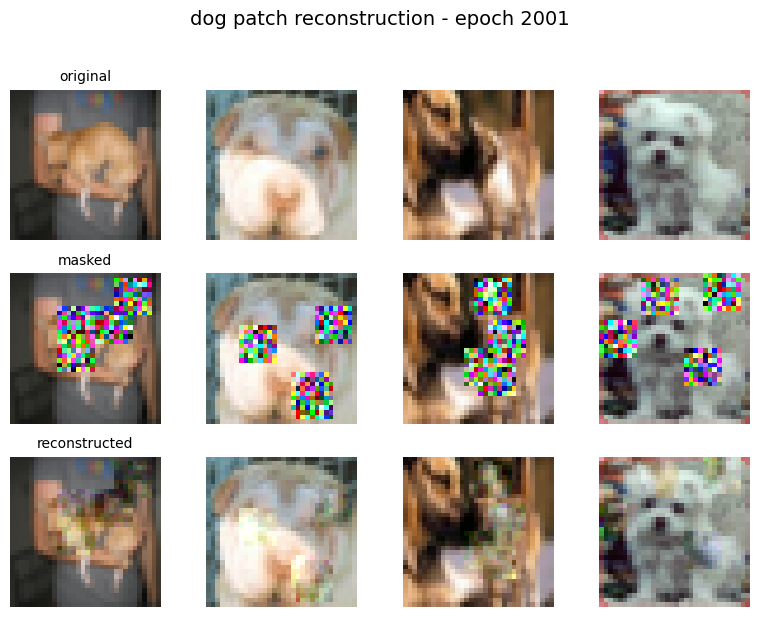

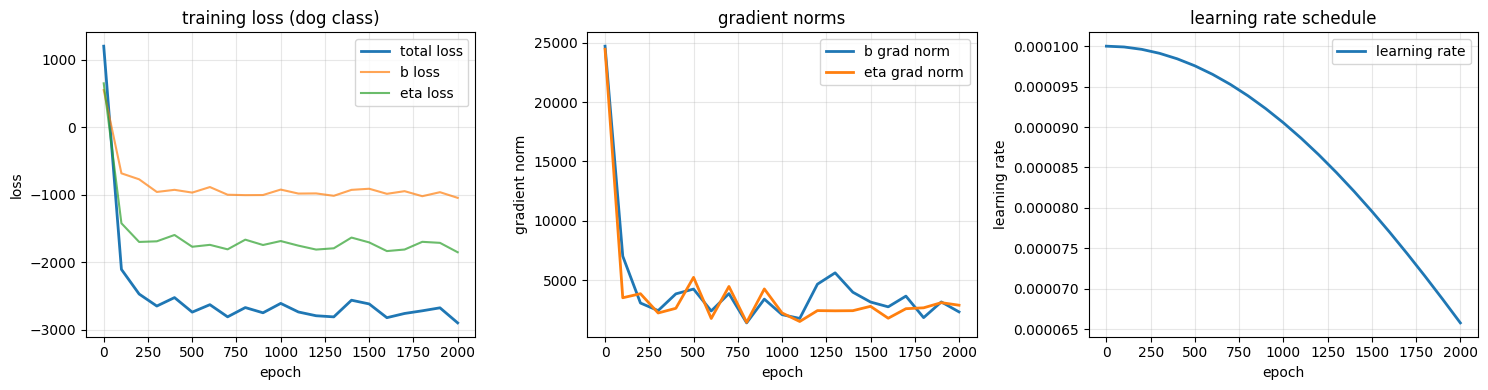

saved checkpoint at epoch 2001
epoch 2101: loss=-2934.1094, b_loss=-1053.4709, eta_loss=-1880.6384
epoch 2201: loss=-2791.1812, b_loss=-1001.7025, eta_loss=-1789.4788
epoch 2301: loss=-2854.3765, b_loss=-1056.8921, eta_loss=-1797.4845
epoch 2401: loss=-2868.9692, b_loss=-1053.9036, eta_loss=-1815.0658


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1211905..2.2767177].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.036795676..0.9185245].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3132486..1.8262281].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.02352941..1.0445907].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9722245..1.9049866].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.059413254..0.87058824].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1

epoch 2501: loss=-2432.5693, b_loss=-909.0729, eta_loss=-1523.4965

epoch: 2501


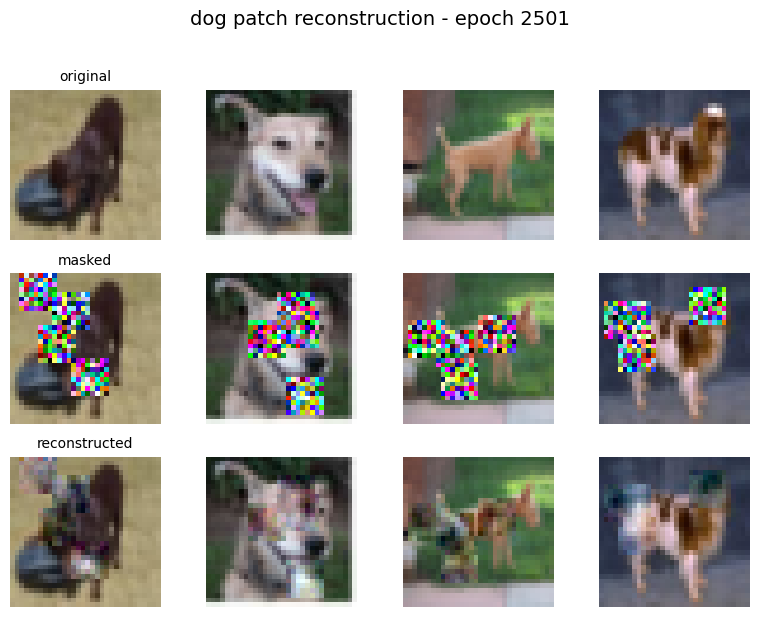

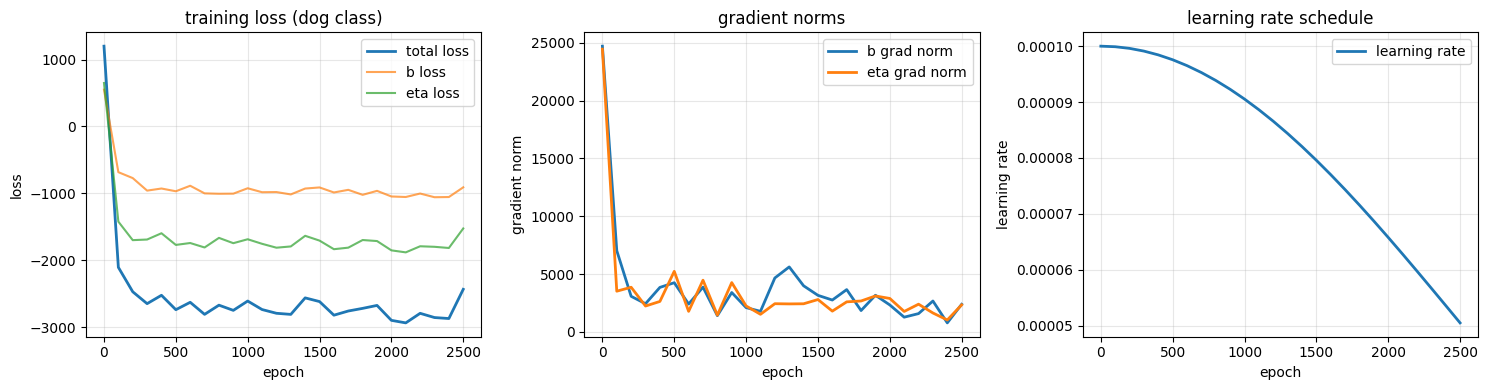

saved checkpoint at epoch 2501
epoch 2601: loss=-2818.5461, b_loss=-1032.1293, eta_loss=-1786.4169
epoch 2701: loss=-2770.3721, b_loss=-1065.1633, eta_loss=-1705.2089
epoch 2801: loss=-2695.8718, b_loss=-995.8582, eta_loss=-1700.0137
epoch 2901: loss=-2726.1587, b_loss=-1017.0263, eta_loss=-1709.1324


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9578191..2.3005004].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.81998837..1.7530441].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.07977432..1.0269763].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.80534875..2.2162027].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4296349..1.8785067].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.086274505..1.0552225].


epoch 3001: loss=-2784.7100, b_loss=-1004.6224, eta_loss=-1780.0874

epoch: 3001


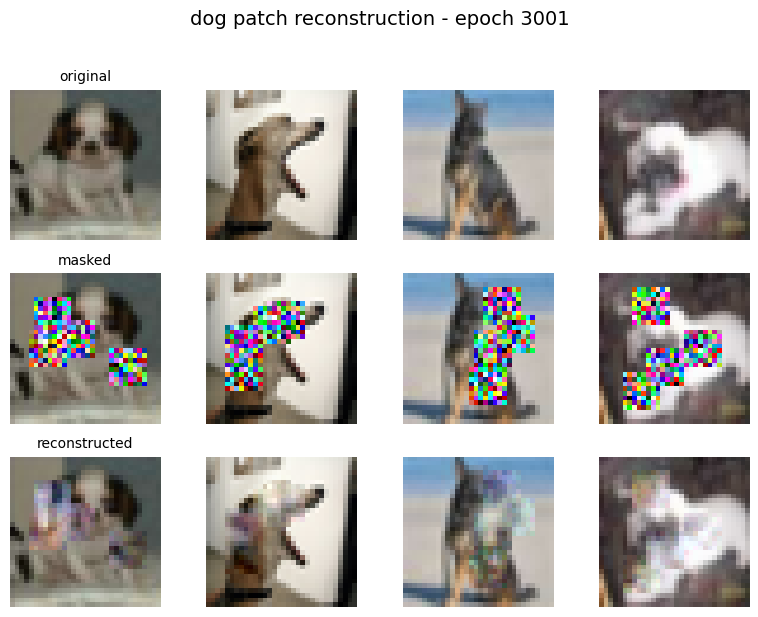

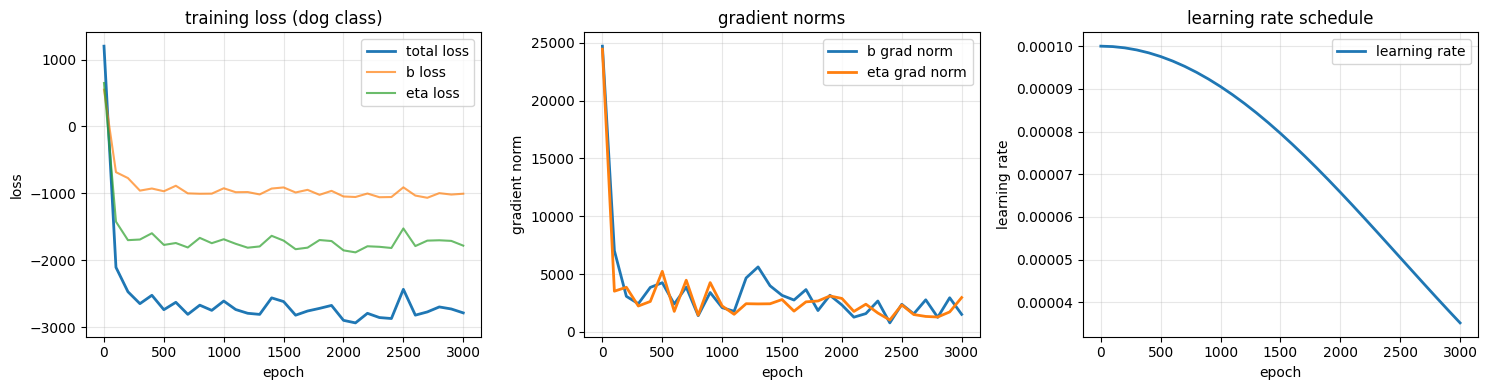

saved checkpoint at epoch 3001
epoch 3101: loss=-2453.1018, b_loss=-917.3887, eta_loss=-1535.7130
epoch 3201: loss=-3039.0808, b_loss=-1085.5292, eta_loss=-1953.5516
epoch 3301: loss=-2640.6423, b_loss=-953.8955, eta_loss=-1686.7468
epoch 3401: loss=-2809.3611, b_loss=-1016.5374, eta_loss=-1792.8236


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9950043..1.9632047].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.1873051..1.0140277].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0102595..2.0233989].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0990051..0.9935137].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.93711126..2.2336369].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.95834064..2.0106816].


epoch 3501: loss=-2816.9226, b_loss=-1014.0754, eta_loss=-1802.8473

epoch: 3501


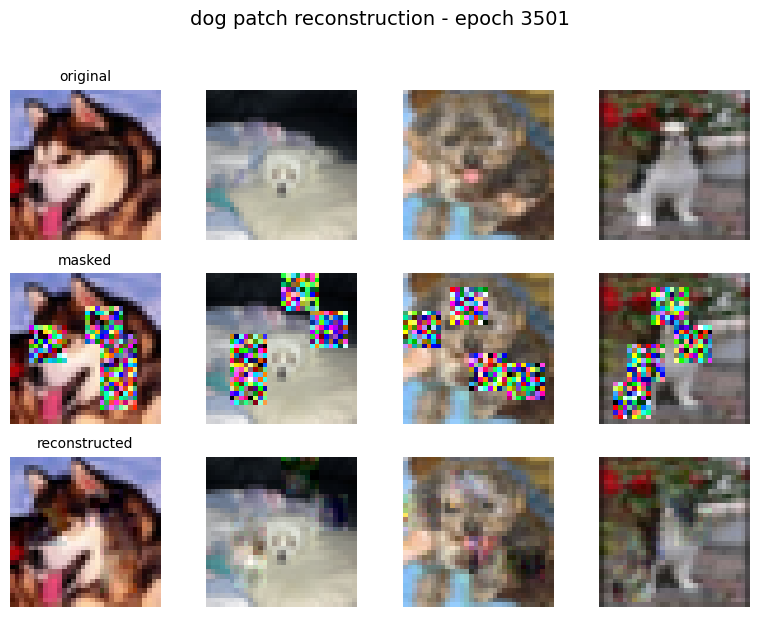

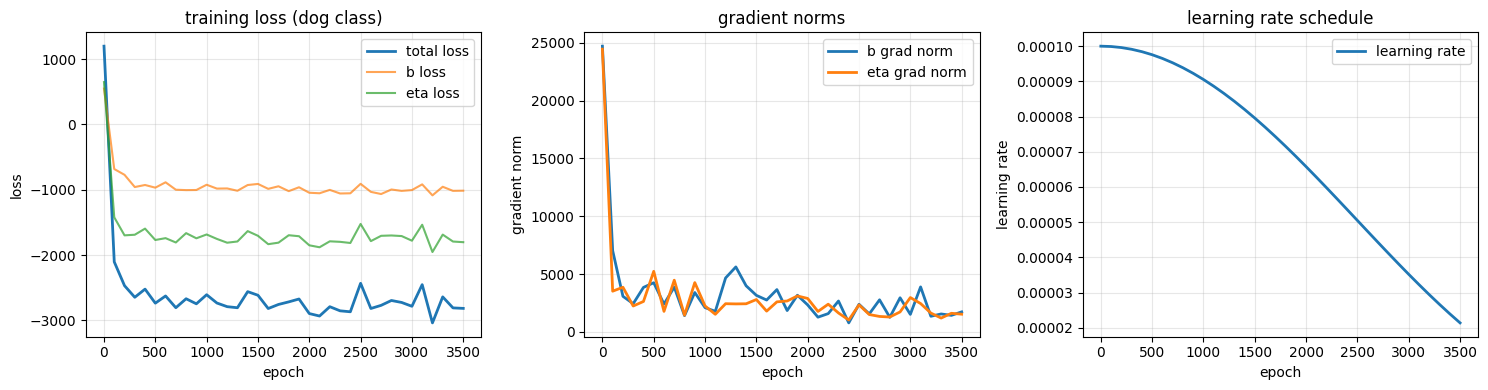

saved checkpoint at epoch 3501
epoch 3601: loss=-3020.5269, b_loss=-1129.2592, eta_loss=-1891.2677
epoch 3701: loss=-2869.2744, b_loss=-1035.1375, eta_loss=-1834.1371
epoch 3801: loss=-2489.5969, b_loss=-908.0054, eta_loss=-1581.5916
epoch 3901: loss=-2912.1238, b_loss=-1063.3158, eta_loss=-1848.8080


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.499787..1.9290458].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.09019607..1.1471171].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1998255..1.8362736].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9802253..1.9342386].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.031297088..1.0349216].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.183443..2.147468].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0172495

epoch 4001: loss=-2866.8674, b_loss=-1059.5619, eta_loss=-1807.3055

epoch: 4001


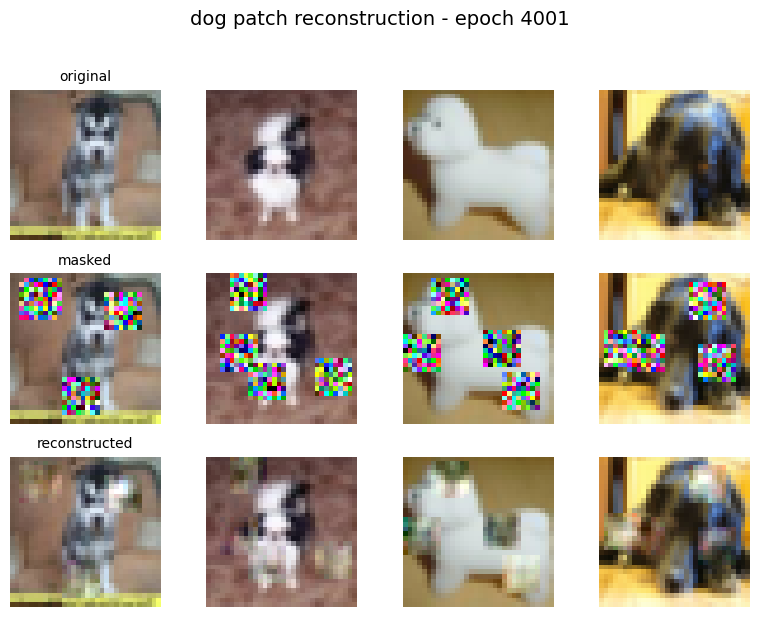

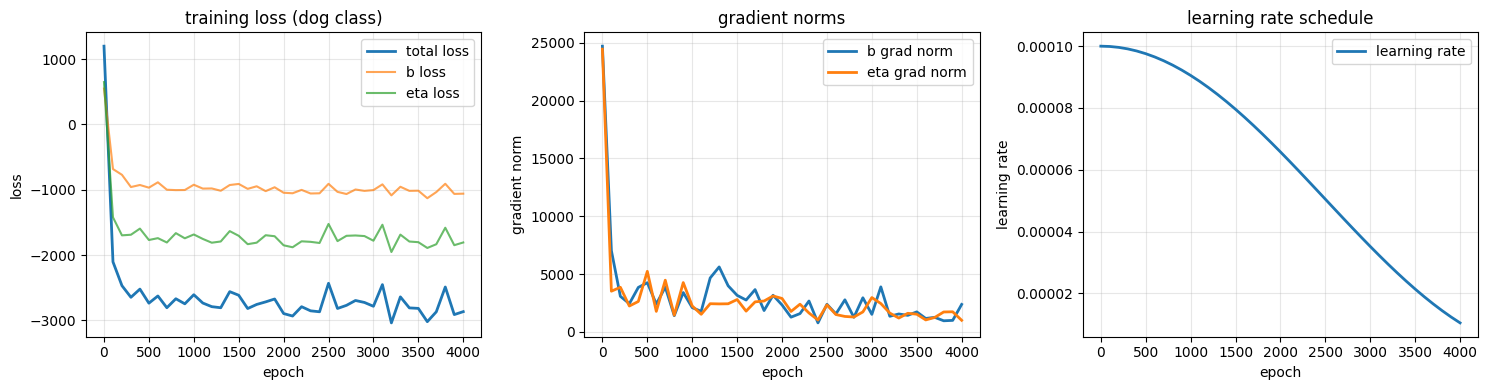

saved checkpoint at epoch 4001
epoch 4101: loss=-2894.6592, b_loss=-1099.8857, eta_loss=-1794.7734
epoch 4201: loss=-2817.5220, b_loss=-1046.8645, eta_loss=-1770.6576
epoch 4301: loss=-2936.4851, b_loss=-1044.6155, eta_loss=-1891.8696
epoch 4401: loss=-2864.9583, b_loss=-1049.8245, eta_loss=-1815.1338


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0692378..2.0677621].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.014060259..0.9529412].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.322365..2.024396].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0494056..2.6181238].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.019163132..0.9763167].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0982392..2.1123524].


epoch 4501: loss=-2619.1636, b_loss=-949.9978, eta_loss=-1669.1656

epoch: 4501


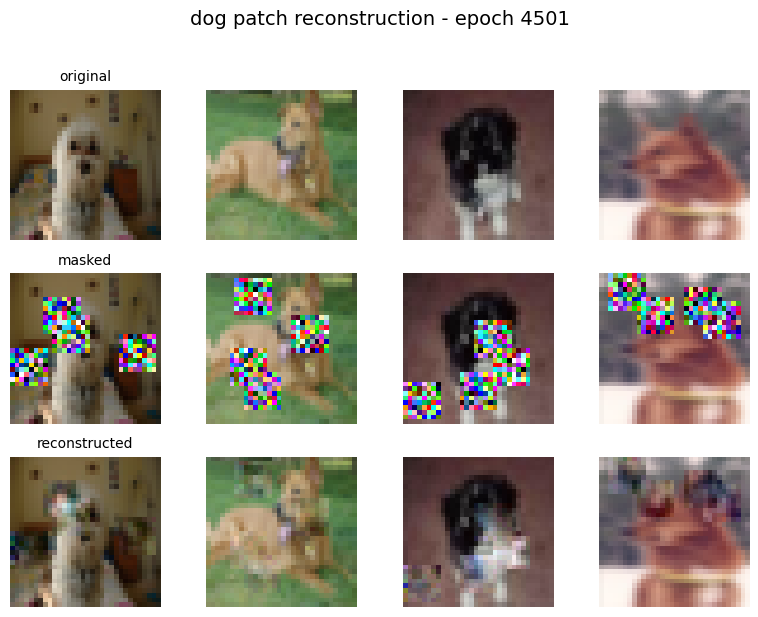

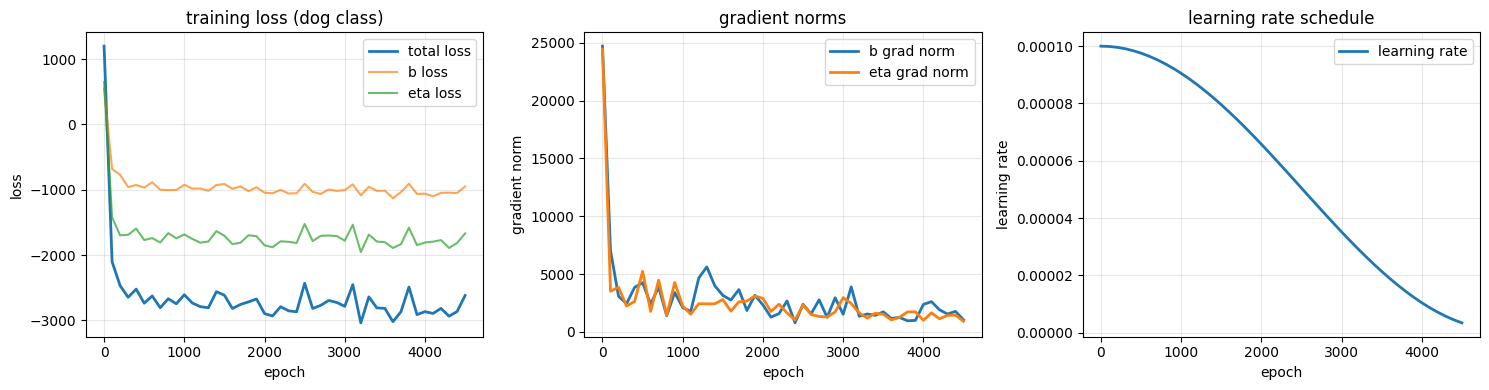

saved checkpoint at epoch 4501
epoch 4601: loss=-2873.9062, b_loss=-1078.4229, eta_loss=-1795.4834
epoch 4701: loss=-2754.1157, b_loss=-1048.9528, eta_loss=-1705.1630
epoch 4801: loss=-2864.2744, b_loss=-1013.7927, eta_loss=-1850.4818
epoch 4901: loss=-2984.7778, b_loss=-1090.8458, eta_loss=-1893.9321

training complete!


In [8]:
if __name__ == "__main__":
    # we set hyperparameters
    base_lr = 1e-4
    batch_size = 32
    n_epochs = 5000
    patch_size = 8
    num_patches = 4
    metrics_freq = 100
    plot_freq = 500
    
    print(f"\nhyperparameters:")
    print(f"  class: dog (cifar10 class 5)")
    print(f"  batch_size: {batch_size}")
    print(f"  learning_rate: {base_lr}")
    print(f"  n_epochs: {n_epochs}")
    print(f"  patch_size: {patch_size}")
    print(f"  num_patches: {num_patches}")
    print(f"\nconditioning approach:")
    print(f"  - networks conditioned on binary mask (visible=1, masked=0)")
    print(f"  - visible pixels kept fixed during generation")
    print(f"  - only masked regions are reconstructed")
    
    # we define interpolant (one-sided linear interpolation)
    path = 'one-sided-linear'
    interpolant = stochastic_interpolant.Interpolant(path=path, gamma_type=None)
    print(f"\nusing interpolant: {path}")
    
    # we define loss functions
    loss_fn_b = stochastic_interpolant.make_loss(
        method='shared', interpolant=interpolant, loss_type='one-sided-b'
    )
    loss_fn_eta = stochastic_interpolant.make_loss(
        method='shared', interpolant=interpolant, loss_type='one-sided-eta'
    )
    
    # we create networks
    print("\ncreating u-net architectures with mask conditioning...")
    unet_b = UNetDenoiser(in_channels=5, out_channels=3, base_channels=64)  # we add mask channel
    unet_eta = UNetDenoiser(in_channels=5, out_channels=3, base_channels=64)  # we add mask channel
    
    b = VelocityNetwork(unet_b).to(itf.util.get_torch_device())
    eta = EtaNetwork(unet_eta).to(itf.util.get_torch_device())
    
    # we count parameters
    n_params_b = sum(p.numel() for p in b.parameters() if p.requires_grad)
    n_params_eta = sum(p.numel() for p in eta.parameters() if p.requires_grad)
    print(f"b network parameters: {n_params_b:,}")
    print(f"eta network parameters: {n_params_eta:,}")
    
    # we create optimizers and schedulers
    opt_b = torch.optim.Adam(b.parameters(), lr=base_lr)
    opt_eta = torch.optim.Adam(eta.parameters(), lr=base_lr)
    sched_b = torch.optim.lr_scheduler.CosineAnnealingLR(opt_b, T_max=n_epochs, eta_min=base_lr*0.01)
    sched_eta = torch.optim.lr_scheduler.CosineAnnealingLR(opt_eta, T_max=n_epochs, eta_min=base_lr*0.01)
    
    # we initialize data dictionary
    data_dict = {
        'losses': [],
        'b_losses': [],
        'eta_losses': [],
        'b_grads': [],
        'eta_grads': [],
        'lrs': []
    }
    
    # we train the model
    print("\nstarting training...\n")
    counter = 1
    for epoch in range(n_epochs):
        loss, b_loss, eta_loss, b_grad, eta_grad = train_step(
            batch_size, interpolant, opt_b, opt_eta, sched_b, sched_eta,
            patch_size, num_patches
        )
        
        # we log metrics
        if (counter - 1) % metrics_freq == 0:
            data_dict['losses'].append(grab(loss).item())
            data_dict['b_losses'].append(grab(b_loss).item())
            data_dict['eta_losses'].append(grab(eta_loss).item())
            data_dict['b_grads'].append(grab(b_grad).item())
            data_dict['eta_grads'].append(grab(eta_grad).item())
            data_dict['lrs'].append(opt_b.param_groups[0]['lr'])
            
            print(f"epoch {counter}: loss={grab(loss).item():.4f}, b_loss={grab(b_loss).item():.4f}, eta_loss={grab(eta_loss).item():.4f}")
        
        # we make plots
        if (counter - 1) % plot_freq == 0:
            make_plots(b, eta, interpolant, counter, data_dict, patch_size, num_patches)
            
            # we save checkpoints
            torch.save({
                'epoch': counter,
                'b_state_dict': b.state_dict(),
                'eta_state_dict': eta.state_dict(),
                'opt_b_state_dict': opt_b.state_dict(),
                'opt_eta_state_dict': opt_eta.state_dict(),
                'data_dict': data_dict,
                'class': 'dog',
                'class_id': 5
            }, f'dog_checkpoint_epoch_{counter}.pt')
            print(f"saved checkpoint at epoch {counter}")
        
        counter += 1
    
    print("\ntraining complete!")